# Imports

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.tree import export_graphviz

random_state = 19

# Load dataset

In [2]:
result_df = pd.read_excel('dataset.xlsx','training_testing',index_col=0,header=0,engine='openpyxl')

In [3]:
display(result_df)

,Product,Elec,Nuc,Success,T,e_x7_LUMO_max,e_x30_dipole(Debye)_min,e_x31_dipole(Debye)_max,e_x34_volume(Bohr_radius³/mol)_min,e_x35_volume(Bohr_radius³/mol)_max,...,n_x99_Sterimol_B1_S_H(Å)_morfeus_max,n_x102_Sterimol_B5_C_S(Å)_morfeus_min,n_x103_Sterimol_B5_C_S(Å)_morfeus_max,n_x106_Sterimol_B5_S_H(Å)_morfeus_min,n_x107_Sterimol_B5_S_H(Å)_morfeus_max,n_x114_Sterimol_L_S_H(Å)_morfeus_min,n_x115_Sterimol_L_S_H(Å)_morfeus_max,n_x142_pyramidalization_Agranat-Radhakrishnan_S_min,n_x146_pyramidalization_Gavrish_S(°)_min,n_x147_pyramidalization_Gavrish_S(°)_max
0,T1,E1,N3,1,90,-0.04255,3.9013,3.9013,930.081,1017.276,...,1.1,3.366479,3.661217,9.463870,9.856770,3.395656,3.397128,1.999996,10.583668,10.586495
1,T2,E1,N1,1,90,-0.04255,3.9013,3.9013,930.081,1017.276,...,1.1,3.281888,3.352155,7.875095,7.910401,3.281926,3.433864,1.999999,10.656670,13.128062
2,T3,E1,N12,1,90,-0.04255,3.9013,3.9013,930.081,1017.276,...,1.1,3.738309,3.738319,9.354187,9.354195,3.396779,3.396780,1.996693,10.597200,10.597201
3,T4,E1,N2,0,90,-0.04255,3.9013,3.9013,930.081,1017.276,...,1.1,6.048494,6.252575,4.520947,7.014201,2.854867,4.612694,1.636442,10.680740,12.440517
4,T5,E1,N34,0,90,-0.04255,3.9013,3.9013,930.081,1017.276,...,1.1,3.288276,3.288279,4.866813,4.866817,3.014886,3.014954,1.999986,10.054826,10.054938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,T149,E76,N1,1,90,-0.04146,4.5199,4.5199,807.879,807.879,...,1.1,3.281888,3.352155,7.875095,7.910401,3.281926,3.433864,1.999999,10.656670,13.128062
149,T150,E76,N35,1,90,-0.04146,4.5199,4.5199,807.879,807.879,...,1.1,3.273970,3.440922,6.613228,6.696521,3.368275,3.410233,2.000000,10.558503,13.124974
150,T151,E8,N30,1,90,-0.05237,2.7859,2.7859,1337.450,1337.450,...,1.1,5.372163,6.773292,6.696067,6.789153,3.447857,6.452175,0.042487,4.506270,10.857796
151,T152,E9,N29,1,90,-0.06417,3.1407,3.1407,1001.079,1001.079,...,1.1,4.497101,4.566781,6.740985,6.973327,3.456592,4.673039,1.999997,10.581713,10.760263


# Decision tree

## Preparing data and visualization of target distribution 

37
There are 53 unsuccessful reactions.
There are 100 successful reactions.


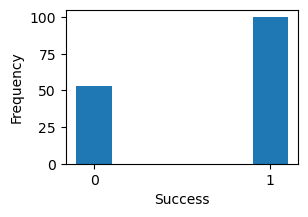

In [4]:
# Create a copy of the training DataFrame 'data'
# data = training_df.copy()
data = result_df.copy()

# Define the starting column index for properties and the response column index
properties_start = 6
response = 4

# Extract features (X) and target (y) from the DataFrame
X = data.iloc[:, properties_start:].values
y = data["Success"]

print(len(X[0]))

# Convert y values to binary classes (0: unsuccess; 1: success)
y_class = np.array([0 if i < 1 else 1 for i in y])
y_class = y_class.astype(int)

# Get the names of the features (X)
X_labelname = data.columns[properties_start:].tolist()

# Count the number of reactions in each class
count_zero = np.count_nonzero(y_class == 0)
print(f"There are {count_zero} unsuccessful reactions.")
count_ones = np.count_nonzero(y_class == 1)
print(f"There are {count_ones} successful reactions.")

# Plot a histogram to visualize the distribution of classes
fig, ax = plt.subplots(figsize=(3, 2))
plt.hist(y_class, bins=[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Success')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.show()

## Grid search to find optimal hyperparameters

In [5]:
# Split the data into training and testing sets (stratified split!)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.30, shuffle=True, random_state=random_state, stratify=y_class)

# Set up KFold cross-validation with 5 splits
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Define the parameter grid for the Decision Tree classifier
param_grid = {
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
}

# Perform grid search using DecisionTreeClassifier and specified parameter grid
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kfold, return_train_score=True)
grid_search.fit(X_train, y_train)

# Print the best parameters and cross-validation score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Best cross-validation score: 0.95


## Training of the final decision tree

Accuracy: 0.89
Precision: 0.89
Recall: 0.87
F1 Score: 0.88


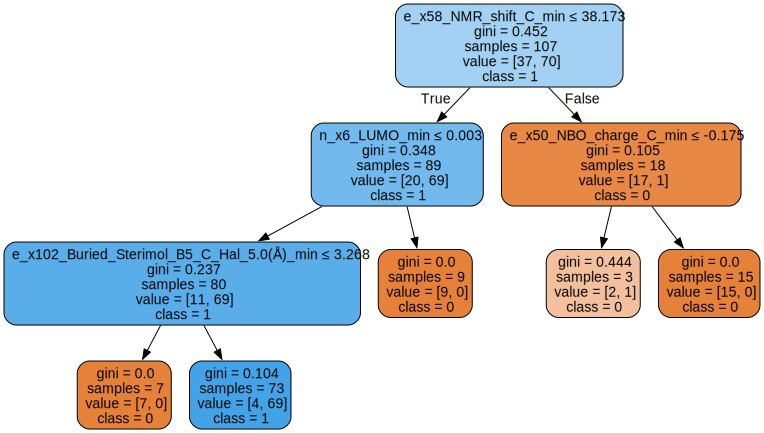

In [6]:
# Define the class weight for the Decision Tree model
class_weight = {0: 1.0, 1: 1.0}

# Create a Decision Tree model with specified hyperparameters and class weight
model_final = DecisionTreeClassifier(
    random_state=random_state,
    max_depth=3,
    criterion='gini',
    min_samples_split=3,
    min_samples_leaf=3,
    max_features=None,
    class_weight=class_weight,
)

# Fit the Decision Tree model to the training data
model_final.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model_final.predict(X_test)

# Calculate and print evaluation metrics (Accuracy, Precision, Recall, F1 Score)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Visualize the Decision Tree using graphviz
dot_data = export_graphviz(model_final, out_file=None,
                           feature_names=X_labelname,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph

## Confusion matrix for the test set performance

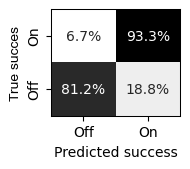

In [7]:
# Plot the confusion matrix with specified labels
fig, ax = plt.subplots(figsize=(2, 1.8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.flipud(cm)

yticklabels = ('Off', 'On')
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%', cbar=False, yticklabels=yticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)

ax.set_xlabel('Predicted success')
ax.set_ylabel('True succes', font="Arial")
ax.set_xticks([0.5, 1.5], ['Off', 'On'])
ax.set_yticks([0.5, 1.5], ['On', 'Off'])

fig.tight_layout()
plt.show()

## KFold cross-validation with 5 splits using the entire dataset

[0.96774194 0.90322581 0.93548387 0.9        0.8       ]
Average cross-validation score: 0.90


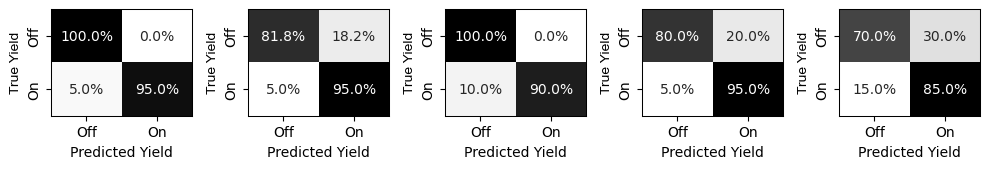

In [8]:
# Set up KFold cross-validation with 5 splits
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Calculate and print the average cross-validation score
scores = cross_val_score(model_final, X, y_class, cv=kfold)
print(scores)
average_score = scores.mean()
print("Average cross-validation score: {:.2f}".format(average_score))

# Perform k-fold cross-validation and store confusion matrices
confusion_matrices = []
for train_idx, test_idx in kfold.split(X, y_class):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_class[train_idx], y_class[test_idx]

    # Train the model on the training data
    model_final_ = model_final.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_final_.predict(X_test)

    # Calculate the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    # Append the confusion matrix to the list
    confusion_matrices.append(cm)

# Create a figure with subplots for each confusion matrix
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(2 * len(confusion_matrices), 1.8))
yticklabels = ('Off', 'On')

# Enumerate over the confusion matrices and plot them in the subplots
for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%', cbar=False, yticklabels=yticklabels, ax=ax)
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.75)

    ax.set_xlabel('Predicted Yield')
    ax.set_ylabel('True Yield', font="Arial")
    ax.set_xticks([0.5, 1.5], ['Off', 'On'])
    ax.set_yticks([0.5, 1.5], ['Off', 'On'])

fig.tight_layout()
plt.show()

# Load validation dataset

In [9]:
#Predict validation reactions:
valid_df = pd.read_excel('dataset.xlsx','validation',index_col=0,header=0,engine='openpyxl')

In [10]:
valid_df

,Product,Elec,Nuc,Success,T,e_x7_LUMO_max,e_x30_dipole(Debye)_min,e_x31_dipole(Debye)_max,e_x34_volume(Bohr_radius³/mol)_min,e_x35_volume(Bohr_radius³/mol)_max,...,n_x99_Sterimol_B1_S_H(Å)_morfeus_max,n_x102_Sterimol_B5_C_S(Å)_morfeus_min,n_x103_Sterimol_B5_C_S(Å)_morfeus_max,n_x106_Sterimol_B5_S_H(Å)_morfeus_min,n_x107_Sterimol_B5_S_H(Å)_morfeus_max,n_x114_Sterimol_L_S_H(Å)_morfeus_min,n_x115_Sterimol_L_S_H(Å)_morfeus_max,n_x142_pyramidalization_Agranat-Radhakrishnan_S_min,n_x146_pyramidalization_Gavrish_S(°)_min,n_x147_pyramidalization_Gavrish_S(°)_max
0,V1,E10,N4,1,90,-0.04349,0.8951,0.8951,1375.861,1375.861,...,1.1,4.345623,4.373471,7.913748,7.914943,3.220122,3.427822,0.302966,6.221530,11.195269
1,V2,E12,N24,1,90,-0.06376,6.7153,6.7153,1173.118,1173.118,...,1.1,4.698886,4.698897,5.691742,5.691749,5.080717,5.080734,1.999997,11.361154,11.361166
2,V3,E26,N3,1,90,-0.04444,5.8928,5.8928,754.104,754.104,...,1.1,3.366479,3.661217,9.463870,9.856770,3.395656,3.397128,1.999996,10.583668,10.586495
3,V4,E38,N3,1,90,-0.07008,3.0452,6.2752,944.056,1339.470,...,1.1,3.366479,3.661217,9.463870,9.856770,3.395656,3.397128,1.999996,10.583668,10.586495
4,V5,E39,N25,1,90,-0.06262,4.7803,5.6432,1344.386,1469.575,...,1.1,3.945132,3.945132,6.748384,6.748384,4.070741,4.070741,2.000000,10.820134,10.820134
5,V6,E40,N26,1,90,-0.07141,7.3482,7.3482,1380.049,1380.049,...,1.1,4.401930,4.599916,7.742233,7.748219,3.394516,4.300701,1.999993,10.608317,10.618506
6,V7,E41,N27,1,90,-0.06503,7.1770,7.1770,1885.661,2167.103,...,1.1,4.503095,4.503095,6.747467,6.747467,4.734241,4.734241,2.000000,10.780595,10.780595
7,V8,E42,N3,1,90,-0.02489,12.0999,22.1286,1703.987,2855.128,...,1.1,3.366479,3.661217,9.463870,9.856770,3.395656,3.397128,1.999996,10.583668,10.586495
8,V9,E43,N28,1,90,-0.04168,1.5336,6.4888,1541.663,2660.619,...,1.1,3.376855,3.376855,8.003144,8.003144,3.396137,3.396137,1.999998,10.605494,10.605494
9,V10,E44,N29,1,90,-0.01692,7.6647,8.1456,1208.495,1469.151,...,1.1,4.497101,4.566781,6.740985,6.973327,3.456592,4.673039,1.999997,10.581713,10.760263


## Preparation of validation data

In [11]:
data_val = valid_df.copy()

# Define the starting column index for properties and the response column index
properties_start = 6
response = 4

# Extract features (X) and target (y) from the DataFrame
X_val = data_val.iloc[:, properties_start:].values
y_val = data_val["Success"]

## Prediction of validation set and confusion matrix

In [12]:
y_pred_val = model_final.predict(X_val)
print(y_pred_val)

[1 1 1 1 1 1 1 1 1 0 0 1 1 0]


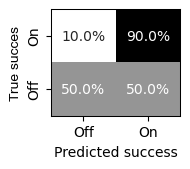

In [13]:
# Plot the confusion matrix with specified labels
fig, ax = plt.subplots(figsize=(2, 1.8))
cm = confusion_matrix(y_val, y_pred_val, normalize='true')
cm = np.flipud(cm)

yticklabels = ('Off', 'On')
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%', cbar=False, yticklabels=yticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)

ax.set_xlabel('Predicted success')
ax.set_ylabel('True succes', font="Arial")
ax.set_xticks([0.5, 1.5], ['Off', 'On'])
ax.set_yticks([0.5, 1.5], ['On', 'Off'])

fig.tight_layout()
# fig.savefig("20240537_cm_allT.png", dpi=600, bbox_inches='tight')
plt.show()